# Семинар 3 - Алгоритмы предварительной обработки изображений и их реализация

***

**Данный семинар содержит домашнее задание - оцениваемые упражнения и вопросы.**

Система оценивания: доля правильно решенных упражений. Максимальный балл, соответственно, 1.

В упражнениях оценивается два аспекта:
1. Код проходит assert'ы (если они есть)
2. Код корректен с точки зрения логики

Вопросы также оцениваются. Ответ на них нужно записывать в соответствующие markdown-ячейки.

In [1]:
from pathlib import Path

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def show_image(img: np.ndarray, title: str = None) -> None:
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

## Свертка (Convolution)

![Пример свертки 1](https://upload.wikimedia.org/wikipedia/commons/6/6e/Convolution_of_box_signal_with_itself.gif "conv1")

![Пример свертки 2](https://upload.wikimedia.org/wikipedia/commons/6/67/Convolution_of_spiky_function_with_box.gif "conv2")

### 1. Определение и интуитивное понимание

Свертка — это **базовая операция в обработке изображений**, используемая для применения фильтров, выделения признаков и улучшения качества изображения.

**Как это работает?**  
Можно представить изображение как матрицу пикселей, а фильтр (ядро) — как небольшую матрицу коэффициентов, которая **скользит** по изображению.  
Каждое значение в новом изображении вычисляется как **взвешенная сумма пикселей окрестности**, умноженная на коэффициенты фильтра.

Применение свертки:
- **Размытие** (например, Гауссово размытие).
- **Выделение границ** (например, операторы Собеля, Лапласиана).
- **Удаление шумов** (медианный фильтр).
- **Детекция объектов** (например, сверточные нейросети).

### 2. Основные свойства свертки

Свертка обладает важными свойствами, которые позволяют комбинировать фильтры и анализировать их поведение.

1. **Коммутативность**  
   $$ f * g = g * f $$  
   (Результат не зависит от порядка функций.)

2. **Ассоциативность**  
   $$ f * (g * h) = (f * g) * h $$  
   (Можно группировать фильтры без изменения результата.)

3. **Дистрибутивность**  
   $$ (f_1 + f_2) * g = f_1 * g + f_2 * g $$  
   (Свертка суммы эквивалентна сумме сверток.)

4. **Линейность**  
   $$ (\alpha f) * g = \alpha (f * g) $$  
   (Константа выносится за знак свертки.)

### 3. Дискретная свертка (применение к изображениям)

В компьютерном зрении используется **дискретная свертка**, так как изображение — это **матрица дискретных значений (пикселей)**.  

Формально, для 1D-сигнала дискретная свертка задается как:

$$ w(t) = \sum\limits_{\tau=0}^{t} g(\tau) \cdot f(t - \tau) $$

**Как это работает в 2D (на изображениях)?**
- Фильтр (ядро) представляет собой небольшую матрицу (например, 3×3 или 5×5).
- Фильтр скользит по изображению, вычисляя **сумму произведений** значений пикселей и коэффициентов фильтра.
- Полученное значение записывается в новую матрицу (результирующее изображение).

**Пример свертки 3×3:**
Если у нас есть изображение:

```
1 2 3
4 5 6
7 8 9
```

и фильтр (ядро):

```
0 -1 0
-1 5 -1
0 -1 0
```

то результат свертки для центрального пикселя **(5)** будет:

$$ (1 \cdot 0) + (2 \cdot -1) + (3 \cdot 0) + (4 \cdot -1) + (5 \cdot 5) + (6 \cdot -1) + (7 \cdot 0) + (8 \cdot -1) + (9 \cdot 0) = 5 $$

Этот процесс повторяется для всех пикселей.

### 4. Связь с частотной областью (интуитивное понимание)

Свертка в пространственной области (по пикселям) **эквивалентна умножению в частотной области**.  
Это означает, что фильтрацию можно выполнять не только с помощью матричных операций, но и через **быстрое преобразование Фурье (БПФ)**.

Простая аналогия:  
- Временная область → работа с изображением в виде матрицы.  
- Частотная область → представление изображения как набора волн разной частоты.  

**Практический вывод:**  
Для больших изображений свертку можно **ускорить**, выполнив **умножение в частотной области**, а затем применив **обратное преобразование Фурье**.

### 5. Визуализация частотной области (интуитивное понимание)

Изображение можно преобразовать в частотную область с помощью **Дискретного преобразования Фурье (ДПФ)**.

- **Модуль спектра** показывает, какие частоты присутствуют в изображении.  
- **Фаза спектра** определяет расположение объектов.  

Фильтры **в частотной области** позволяют:
- Подавлять шум (например, фильтр нижних частот).
- Усиливать детали (фильтр высоких частот).
- Удалять повторяющиеся паттерны (например, муар).

Хотя анализ в частотной области важен для некоторых задач (обнаружение текстур, шумоподавление), в большинстве случаев **пространственные фильтры** (обычные ядра) более удобны.

### Вывод

Свертка — это **основной инструмент** обработки изображений.  
- **Понимание 2D-свертки и работы фильтров обязательно** (пункты 1-3).  
- **Частотные методы полезны**, но не всегда нужны для прикладных задач (пункты 4-5).  
- Использование **преобразования Фурье** ускоряет свертку, но обычно применяется для специфических задач.


## Анализ влияния шума на частотные характеристики сигнала (Дополнительный материал для самостоятельного изучения)

Этот материал предназначен для самостоятельного изучения дома. Он поможет лучше понять, как разные типы шума влияют на частотное представление сигнала и почему при обработке изображений важно учитывать частотные характеристики.

Рассмотрим несколько стандартных моделей шума
1. $\textbf{Соль и перец}$ - случайные черные и белые пиксели
2. $\textbf{Импульсный}$ - случайные белые пиксели
3. $\textbf{Гауссов}$ - колебания яркости, распределенные по нормальному закону

Проанализируем часть из них на одномерных массивах.

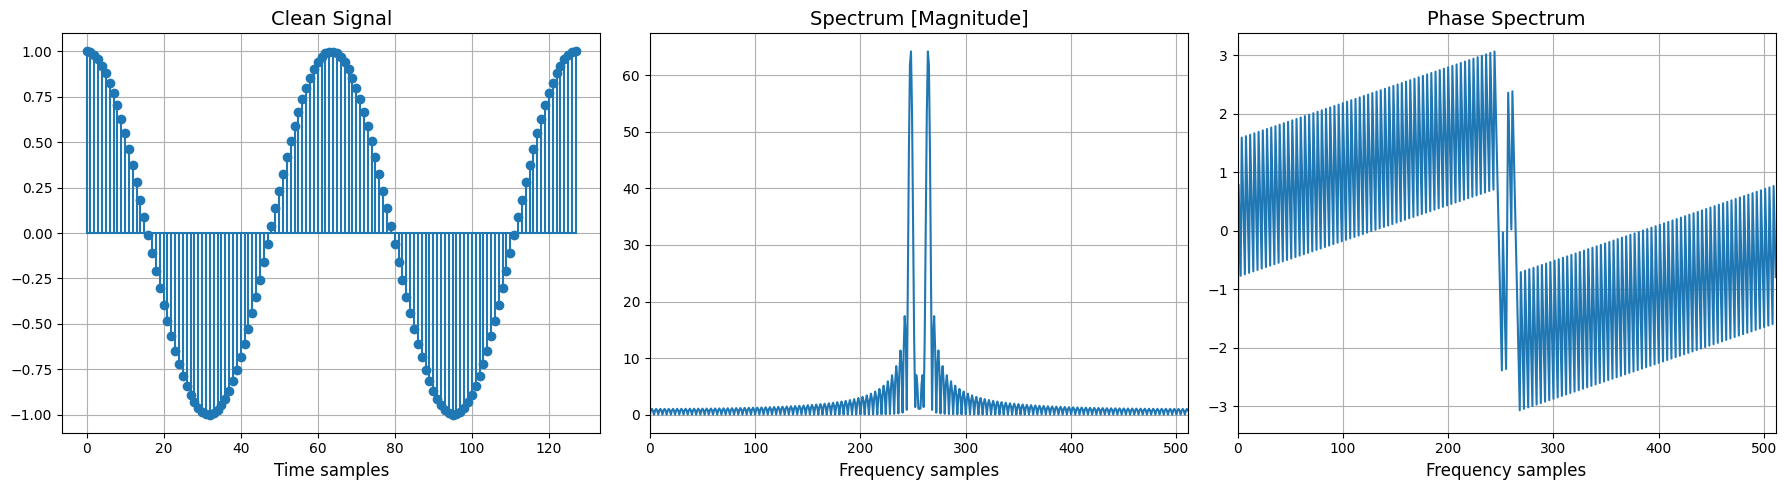

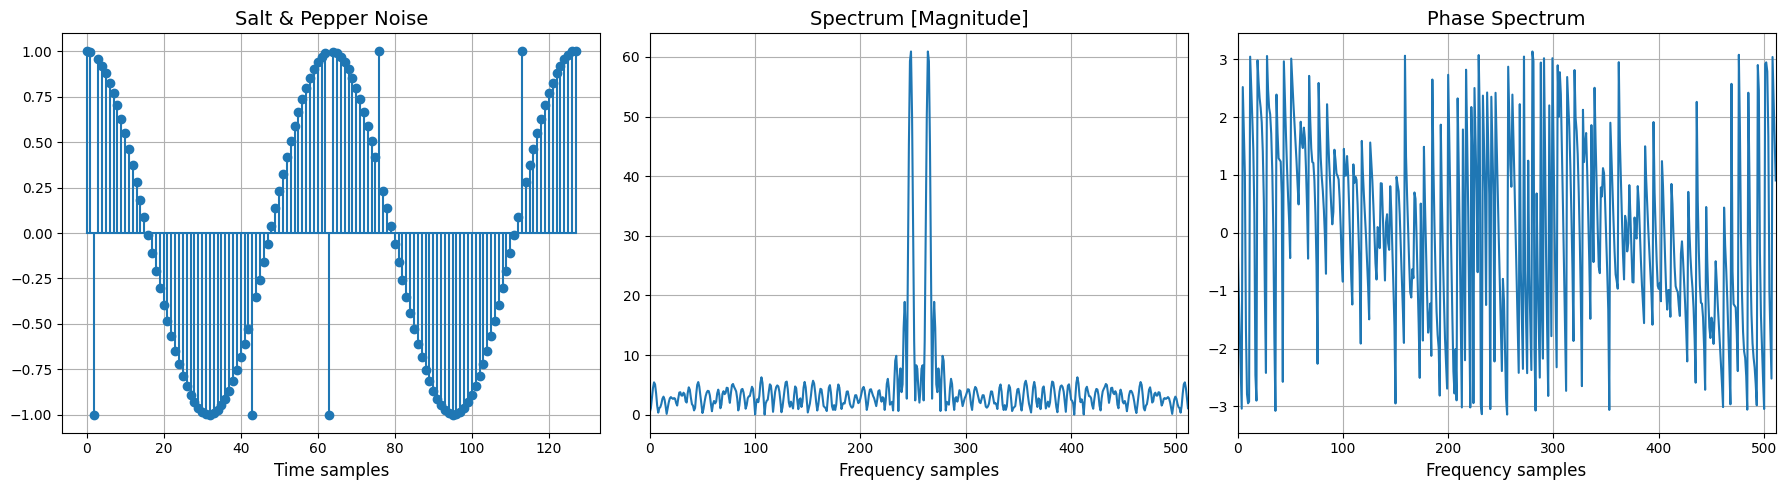

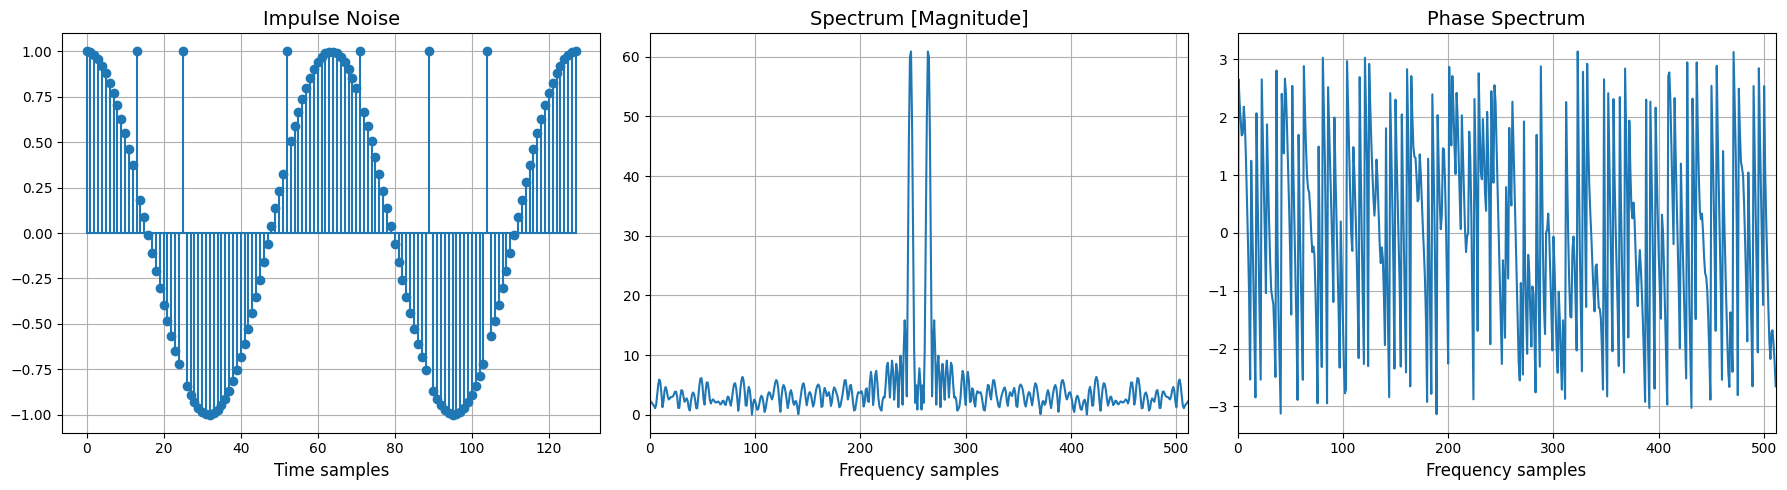

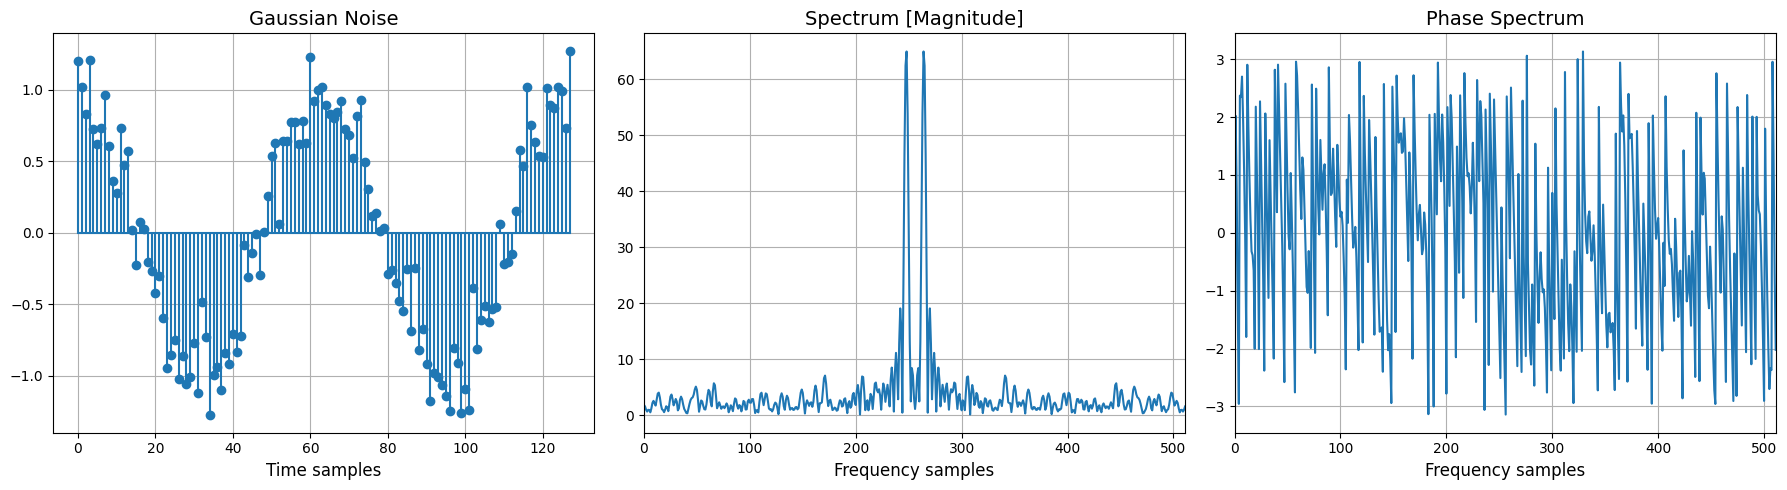

In [3]:
from scipy.fftpack import fft, fftshift


def viz_signal(signal: np.array, title: str) -> None:
    """Visualization of the input signal, its amplitude, and phase spectra.

    Args:
        signal (np.array): Input 1D signal.
        title (str): Title of the signal plot.
    """

    # Длина сигнала (используется для FFT)
    N = 512
    xFFT = fftshift(fft(signal, N))

    # Амплитудный спектр
    xA = np.abs(xFFT)

    # Фазовый спектр
    xF = np.angle(xFFT)

    # Список сигналов для отображения
    signals = [signal, xA, xF]
    titles = [f'{title}', 'Spectrum [Magnitude]', 'Phase Spectrum']

    # Отрисовка результатов
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (sig, ax) in enumerate(zip(signals, axes)):
        ax.set_title(titles[i], fontsize=14)
        ax.grid()
        if i == 0:
            ax.stem(sig, basefmt='C0')
            ax.set_xlabel('Time samples', fontsize=12)
        else:
            ax.plot(sig)
            ax.set_xlabel('Frequency samples', fontsize=12)
            ax.set_xlim([0, N - 1])

    plt.tight_layout()
    plt.show()


# Генерация тестовых сигналов
N = 128
t = np.linspace(0, 1, N)

# Чистый сигнал
f1 = 2
signal_clean = np.cos(2 * np.pi * f1 * t)

# Сигнал с шумом "Соль и перец"
signal_sp = signal_clean.copy()
indices = np.random.choice(N, size=int(0.05 * N), replace=False)
signal_sp[indices] = np.random.choice([-1, 1], size=len(indices))

# Сигнал с импульсным шумом
signal_impulse = signal_clean.copy()
indices = np.random.choice(N, size=int(0.05 * N), replace=False)
signal_impulse[indices] = 1

# Сигнал с гауссовым шумом
signal_gaussian = signal_clean + 0.2 * np.random.normal(size=N)

# Визуализация сигналов и их спектров
viz_signal(signal_clean, "Clean Signal")
viz_signal(signal_sp, "Salt & Pepper Noise")
viz_signal(signal_impulse, "Impulse Noise")
viz_signal(signal_gaussian, "Gaussian Noise")


### Анализ результатов

#### 1. Чистый сигнал (Clean Signal)

- Исходный сигнал – **синусоида** без шума.
- **Амплитудный спектр:** содержит **два пика**, так как косинус представляет собой сумму двух экспонент – одна с положительной, другая с отрицательной частотой.
- **Фазовый спектр:** наблюдается **резкий переход в центре** из-за симметрии частотного представления сигнала.

**Вывод:** Чистый сигнал имеет **четкую частотную структуру**, но из-за преобразования Фурье и перестановки частот (`fftshift`) в фазовом спектре появляется резкий скачок.

#### 2. Шум "Соль и перец" (Salt & Pepper Noise)

- Добавлены случайные **черные и белые точки** (скачки значений в сигнале).
- **Амплитудный спектр:** появляются **высокочастотные составляющие**, но основной пик остается видимым.
- **Фазовый спектр:** стал **хаотичным**, так как случайные импульсы в сигнале приводят к резким фазовым сдвигам.

**Вывод:** Шум "Соль и перец" **добавляет резкие изменения** в сигнал, что вносит хаотичные компоненты в частотное представление.

#### 3. Импульсный шум (Impulse Noise)

- В отличие от "Соли и перца", добавлены **только положительные всплески**.
- **Амплитудный спектр:** больше **энергии в высоких частотах**, но основная частота все еще заметна.
- **Фазовый спектр:** скачки фазового спектра становятся **еще более резкими**, так как импульсы нарушают гармоническую структуру сигнала.

**Вывод:** Импульсный шум еще сильнее **искажает фазу**, но в амплитудном спектре его влияние похоже на "Соль и перец".

#### 4. Гауссов шум (Gaussian Noise)

- Добавлен **случайный шум**, распределенный по **нормальному закону**.
- **Амплитудный спектр:** шум **распределен равномерно** по всему спектру, размывая основной пик.
- **Фазовый спектр:** стал **размытым**, но без резких скачков, так как шум распределен более равномерно.

**Вывод:** Гауссов шум **размывает частотную структуру сигнала** и приводит к плавным изменениям фазы.

### Общий вывод

- **Чистый сигнал** имеет четкую частотную структуру, но его спектр состоит из двух пиков, а в фазе наблюдается резкий переход из-за перестановки частот.
- **Шумы "Соль и перец" и импульсный шум** вносят **высокочастотные составляющие**, делая фазовый спектр хаотичным.
- **Гауссов шум** размывает частотный спектр, но фаза изменяется плавно.


## Вопрос 1

**Этот и дальнейшие вопросы и упражнения будут оцениваться**

Почему в амплитудном спектре чистого сигнала наблюдаются два пика, а не один?

**Ответ:**

Сигналы при представлении в виде комплексных чисел симметричны и поэтому пики отражают положительные и отрицательные частоты пиков


## Вопрос 2

Какой тип шума приводит к хаотичным изменениям в фазовом спектре и почему?

**Ответ:**

"Соль и перец" и Импульсный шум

Они вносят резкие всплески в сигнал, которые вносят искажения в фазу и в фазовых спектрах


## Вопрос 3

Чем влияние гауссового шума на амплитудный спектр отличается от влияния шума "Соль и перец"?

**Ответ:**

Гауссов шум размывается по всему сигналу с нормальным распределением, а "Соль и перец" имеет редкие, но значительные пики сигналов.


## Шумы на изображениях

## Упражнение 1

Реализуйте шумы типа соль/перец и гаусов шум. Визуализируйте результаты - добавьте шум к предложенному изображению астронавта.

In [4]:
def saltpepper_noise(
    image: np.array,
    proportion: float=0.2,
) -> np.array:
    result = image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if np.random.random() < proportion:
                result[i][j] = np.random.choice([-255, 255])
            else:
                result[i][j] = image[i][j]
    return result

def gaussian_noise(
    image: np.array,
    mean: float=0.04,
    sigma: float=0.07,
) -> np.array:
    result = np.random.normal(loc=mean, scale=sigma, size=image.shape)
    result = image + result * 255
    return np.clip(result, 0, 255).astype(int)

def do_nothing(
    image: np.array,
) -> np.array:
    return image

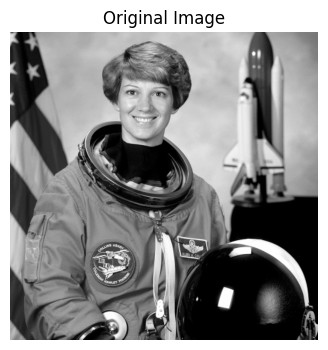

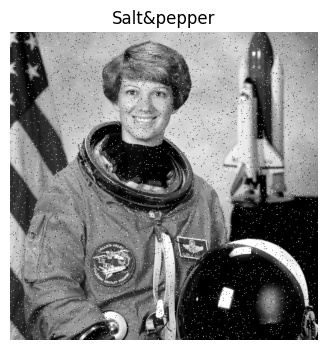

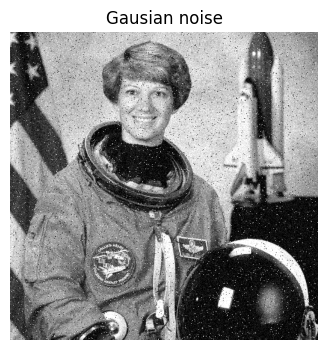

In [5]:
img = cv2.cvtColor(
    src=skimage.data.astronaut(),
    code=cv2.COLOR_RGB2GRAY,
)

show_image(img, title='Original Image')
show_image(saltpepper_noise(img, 0.03), title='Salt&pepper')
show_image(gaussian_noise(img), title='Gausian noise')

## Упражнение 2

Посмотрите также разницу на других фотографиях - они доступны в `skimage.data`

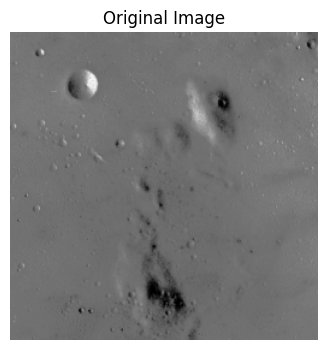

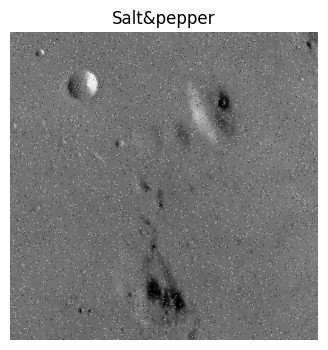

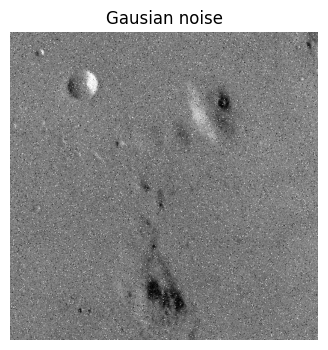

In [6]:
img = skimage.data.moon()
show_image(img, title='Original Image')
show_image(saltpepper_noise(img, 0.03), title='Salt&pepper')
show_image(gaussian_noise(img), title='Gausian noise')

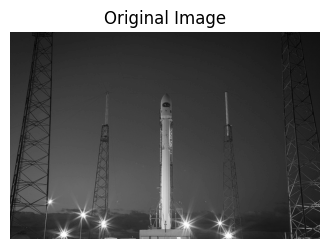

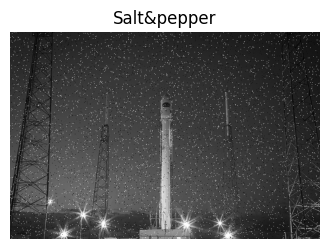

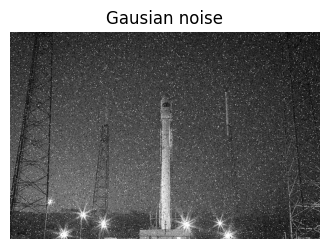

In [7]:
img = cv2.cvtColor(
    src=skimage.data.rocket(),
    code=cv2.COLOR_RGB2GRAY,
)

show_image(img, title='Original Image')
show_image(saltpepper_noise(img, 0.03), title='Salt&pepper')
show_image(gaussian_noise(img), title='Gausian noise')

## Базовые фильтры

![](http://www.djvu-soft.narod.ru/bookscanlib/cf1.jpg)

![](http://www.djvu-soft.narod.ru/bookscanlib/cf2.jpg)

Рассмотрим линейные фильтры, основанные, конечно же, на конволюции.

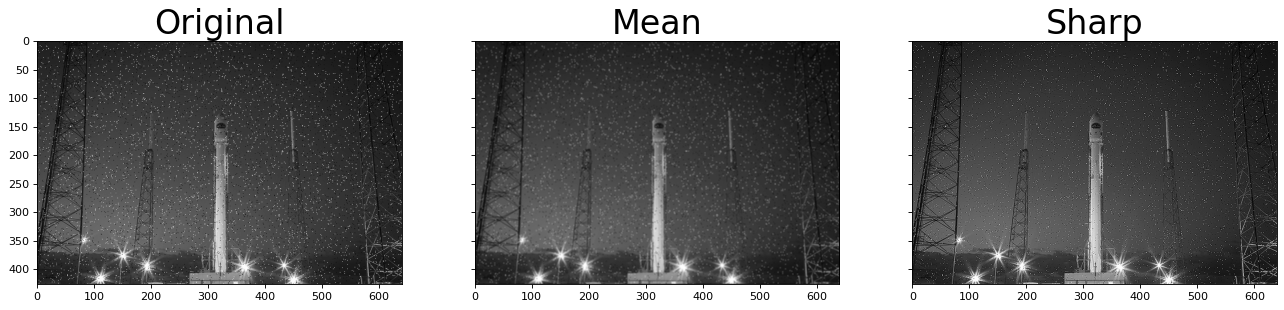

In [8]:
nothing = np.array([
    [1., ],
])

mean = np.array([
    [1, 1, 1, ],
    [1, 1, 1, ],
    [1, 1, 1, ],
]) / 9

sharp = np.array([
    [0, -1, 0, ],
    [-1, 9, -1, ],
    [0, -1, 0, ],
]) / 5

filters = [nothing, mean, sharp, ]
lst_title = ['Original', 'Mean', 'Sharp', ]

fig, axes = plt.subplots(
    ncols=len(lst_title),
    sharex=True,
    sharey=True,
    figsize=(20, 10),
    dpi=80,
)
for i in range(len(filters)):

    filtered_img = cv2.filter2D(
        src=img,
        kernel=filters[i],
        ddepth=-1, #the same depth as input
        borderType=cv2.BORDER_CONSTANT,
        anchor=(-1, -1), #center of the kernel
        delta=0, #additional data added to
    )

    axes[i].imshow(filtered_img, cmap='gray')
    axes[i].set_title(lst_title[i], fontsize=30)

Особенность свертки - ее локальность. Чем больше ядро светки - тем в большей окрестности она охватывает пиксели.

## Упражение 3

Реализуйте свою свертку и сравните с реализацией `cv2.filter2D` (визуализируйте результаты работы своей свертки и библиотечной с одинаковым ядром + посмотрите на разность значений пикселей после обработки).

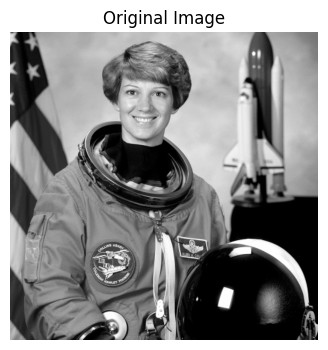

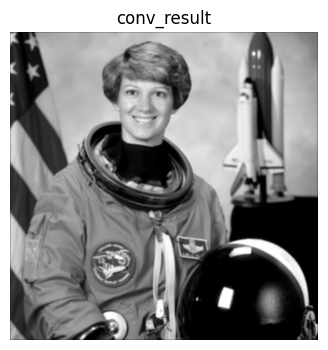

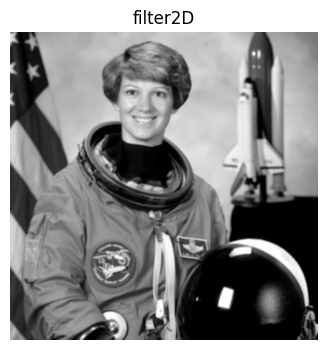

max_diff = 95.44444
mean_diff = 0.49421054


In [9]:
def conv(image, kernel):
    h, w = kernel.shape
    pad_result = np.pad(image, h // 2, mode='constant', constant_values=0)
    result = np.zeros((image.shape[0], image.shape[1]))
    for i in range(image.shape[1]):
        for j in range(image.shape[0]):
            region = pad_result[i:i+h, j:j+h]
            result[i, j] = np.sum(region * kernel)
    return result

kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]], dtype=np.float32) / 9
img = cv2.cvtColor(skimage.data.astronaut(), cv2.COLOR_RGB2GRAY)
conv_result = conv(img, kernel)

etalon = cv2.filter2D(img, -1, kernel)

show_image(img, title='Original Image')
show_image(conv_result, title='conv_result')
show_image(cv2.filter2D(img, -1, kernel), title='filter2D')

difference = np.abs(conv_result.astype(np.float32) - etalon.astype(np.float32))
print(f"max_diff = " + str(np.max(difference)))
print(f"mean_diff = " + str(np.mean(difference)))

## Нелинейные фильтры

Рассмотрим нелинейные фильтры. В отличие от линейных, они могут адаптироваться к локальным особенностям изображения и учитывать сложные структуры. Такие фильтры часто используются для шумоподавления, улучшения контраста и выделения деталей.


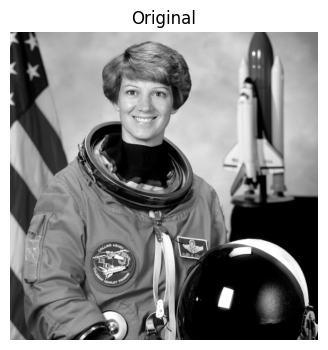

In [10]:
img = cv2.cvtColor(skimage.data.astronaut(), cv2.COLOR_RGB2GRAY)
show_image(img, 'Original')

### Медианный фильтр

Медианный фильтр заменяет каждый пиксель изображения на медиану значений в его окрестности. Он особенно эффективен для удаления импульсного шума (например, "соляного и перечного" шума), поскольку не размывает границы так сильно, как линейные сглаживающие фильтры.

```python
filtered_img = cv2.medianBlur(
    src=img,
    ksize=5  # Размер окна фильтра (должен быть нечетным)
)
```

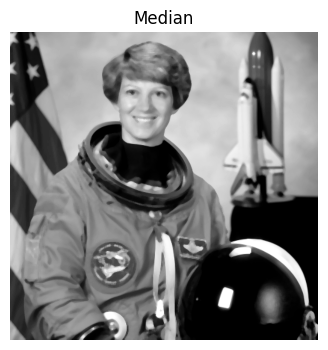

In [11]:
median_filtered = cv2.medianBlur(img, ksize=5)
show_image(median_filtered, 'Median')

### Гистограммное выравнивание (Histogram Equalization)

Этот метод перераспределяет уровни яркости в изображении так, чтобы его гистограмма стала более равномерной. Это помогает улучшить контраст, особенно в случаях, когда изображение выглядит слишком темным или слишком светлым.

```python
filtered_img = cv2.equalizeHist(
    src=img,
)
```

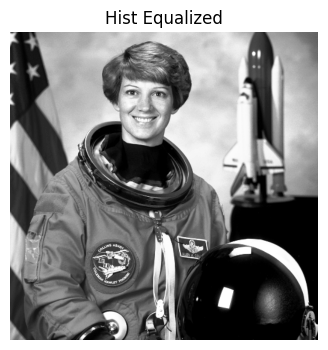

In [12]:
hist_equalized = cv2.equalizeHist(img)
show_image(hist_equalized, 'Hist Equalized')

### Contrast Limited Adaptive Histogram Equalization (CLAHE)

CLAHE — адаптивная версия гистограммного выравнивания, которая применяется не ко всему изображению сразу, а к его небольшим участкам (тайлам). Это позволяет избежать чрезмерного усиления контраста в однородных областях.

```python
clahe = cv2.createCLAHE(
    clipLimit=40.0,  # Порог для ограничения контраста
    tileGridSize=(8, 8)  # Размер сетки разбиения изображения
)
filtered_img = clahe.apply(img)
```

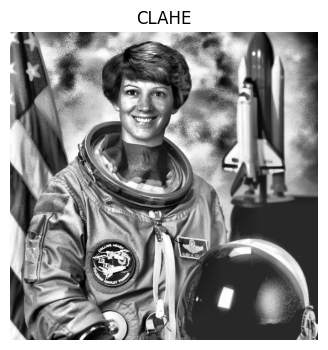

In [13]:
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8, 8))
clahe_filtered = clahe.apply(img)
show_image(clahe_filtered, 'CLAHE')

### Билатеральный фильтр (Bilateral Filter)

Этот фильтр позволяет сглаживать изображение, сохраняя при этом резкие границы. Он использует как пространственную близость пикселей, так и различие в интенсивности, что делает его особенно полезным для обработки фотографий и медицинских изображений.

```python
filtered_img = cv2.bilateralFilter(
    src=img,
    d=9,  # Диаметр области сглаживания
    sigmaColor=75,  # Градиентный разброс по цвету
    sigmaSpace=75,  # Градиентный разброс по пространству
    borderType=cv2.BORDER_CONSTANT,
)
```

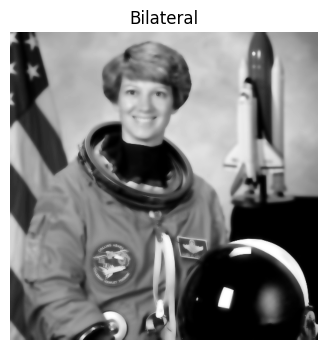

In [14]:
bilateral_filtered = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
show_image(bilateral_filtered, 'Bilateral')

## Гистограмное Выравнивание

Рассмотрим изображение, значения пикселей которого ограничены только определенным диапазоном значений. Например, на более ярком изображении все пиксели будут находиться в верхней части диапазона яркости, а на темном – в нижней. В идеальном случае изображение должно иметь широкий диапазон уровней яркости, что способствует лучшему восприятию деталей.


### Что делает гистограмное выравнивание?

Гистограммное выравнивание – это метод обработки изображений, который перераспределяет уровни яркости пикселей таким образом, чтобы гистограмма стала равномернее. Это помогает растянуть или сместить значения интенсивности, увеличивая контраст и делая детали изображения более различимыми.


### Алгоритм работы

Алгоритм гистограммного выравнивания состоит из следующих шагов:

1. **Вычисление гистограммы** – сначала вычисляется гистограмма изображения, которая представляет собой распределение значений интенсивности пикселей.
2. **Нахождение функции распределения (CDF, Cumulative Distribution Function)** – вычисляется интегральная гистограмма (кумулятивное распределение), которая показывает, сколько пикселей имеют интенсивность, меньшую или равную определенному значению.
3. **Нормализация CDF** – перевод значений CDF в диапазон от 0 до 255 (или другой диапазон, зависящий от битности изображения).
4. **Замена интенсивностей пикселей** – каждому значению интенсивности пикселя в исходном изображении соответствует новое значение, найденное по нормализованной CDF. В результате пиксели перераспределяются, и контраст изображения увеличивается.


### Пример кода

In [15]:
def plot_hist(img: np.ndarray, title: str = None) -> None:
    """Visualizes the image and its histogram along with the CDF (Cumulative Distribution Function).

    Args:
        img (np.ndarray): Input grayscale image.
    """

    # Создаем фигуру с двумя подграфиками: для изображения и для гистограммы с CDF
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5), dpi=80)

    # Отображение исходного изображения
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title(title)
    axes[0].axis("off")

    # Вычисление гистограммы изображения (256 бинов)
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])

    # Вычисление кумулятивной функции распределения (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()  # Нормализация CDF для отображения на графике

    # Построение графиков гистограммы и CDF
    axes[1].hist(img.flatten(), bins=256, range=[0, 256], color='r', alpha=0.6, label="Гистограмма")
    axes[1].plot(cdf_normalized, color='b', label="CDF")  # Кумулятивная функция распределения
    axes[1].set_xlim([0, 256])
    axes[1].legend(loc='upper left')
    axes[1].set_title("Гистограмма и CDF")

    plt.show()


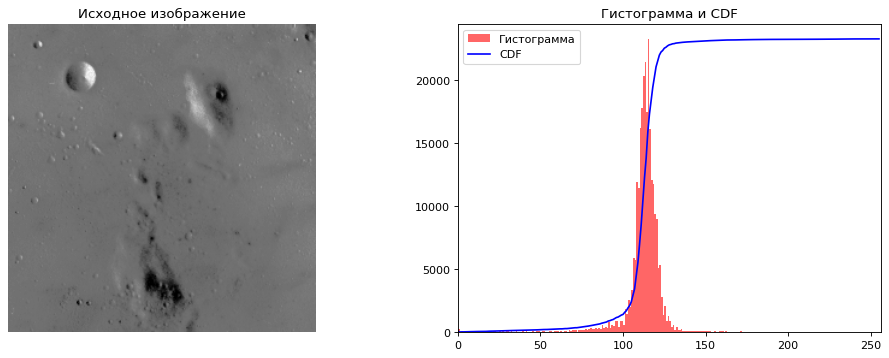

In [16]:
img = skimage.data.moon()

plot_hist(img, "Исходное изображение")

Реализуем функцию для гистограммного выравнивания самостоятельно, с помощью numpy:

In [17]:
def histogram_equalization(img: np.ndarray) -> np.ndarray:
    """Implements histogram equalization manually using numpy.

    Args:
        img (np.ndarray): Input grayscale image (2D array).

    Returns:
        np.ndarray: Image after histogram equalization.
    """

    # 1. Вычисляем гистограмму изображения (256 уровней серого)
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])

    # 2. Вычисляем кумулятивную функцию распределения (CDF)
    cdf = hist.cumsum()  # Накопленная сумма значений гистограммы
    cdf_min = cdf[cdf > 0].min()  # Минимальное ненулевое значение CDF (исключаем нулевые значения)

    # 3. Нормализуем CDF в диапазон [0, 255]
    cdf_normalized = ((cdf - cdf_min) / (cdf.max() - cdf_min)) * 255
    cdf_normalized = np.round(cdf_normalized).astype(np.uint8)  # Округляем и приводим к uint8

    # 4. Применяем трансформацию к изображению
    img_equalized = cdf_normalized[img]  # Заменяем интенсивности пикселей новыми значениями

    return img_equalized


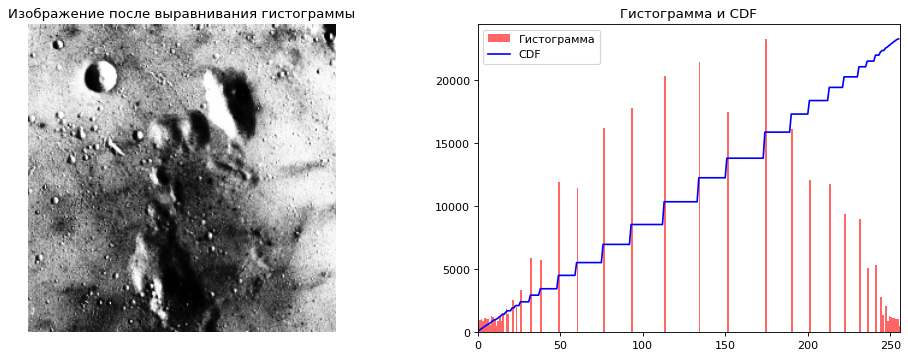

In [18]:
img_equalized_custom = histogram_equalization(img)
plot_hist(img_equalized_custom, "Изображение после выравнивания гистограммы")

Сравним результаты работы нашей функции и функции `cv2.equalizeHist`:

In [19]:
img_equalized_cv2 = cv2.equalizeHist(img)
# Проверяем разницу между результатами
diff = np.abs(img_equalized_custom.astype(np.int16) - img_equalized_cv2.astype(np.int16))
max_diff = np.max(diff)  # Максимальная разность значений пикселей
print(max_diff)

0


### Contrast Limited Adaptive Histogram Equalization (CLAHE)

#### Основная суть алгоритма

CLAHE (ограниченное адаптивное выравнивание гистограммы) – это метод улучшения контраста, который решает проблемы стандартного гистограммного выравнивания. Вместо обработки всего изображения сразу, CLAHE делит его на небольшие блоки (тайлы) и выполняет выравнивание отдельно в каждом из них. Это помогает сохранить детали в локальных областях, а также избежать чрезмерного усиления контраста.

Дополнительно метод использует **ограничение контраста (Clip Limit)**, что предотвращает чрезмерное усиление шума в однородных областях изображения.

#### Детали работы алгоритма

1. **Разделение изображения на тайлы**  
   - Исходное изображение делится на сетку тайлов размером `tile_grid_size` (например, 8×8).  
   - Каждый тайл обрабатывается независимо.

2. **Гистограммное выравнивание в каждом тайле**  
   - Для каждого тайла вычисляется гистограмма.
   - Строится **кумулятивная функция распределения (CDF)** для преобразования значений пикселей.

3. **Ограничение контраста (Clip Limit)**  
   - Если какое-то значение интенсивности встречается слишком часто (выше `clip_limit`), избыточные пиксели перераспределяются между остальными уровнями яркости.  
   - Это предотвращает резкие скачки контраста и сильное усиление шума.

4. **Интерполяция между тайлами**  
   - Чтобы избежать резких границ между обработанными областями, OpenCV использует **двумерную билинейную интерполяцию**, сглаживая переходы.  
   - Без интерполяции возможны резкие переходы между тайлами.

5. **Замена значений пикселей**  
   - После обработки каждого тайла значения пикселей заменяются новыми, рассчитанными на основе его локальной CDF.

#### Отличия CLAHE от обычного гистограммного выравнивания

| Фактор | Обычное выравнивание | CLAHE |
|--------|---------------------|-------|
| Глобальное/локальное | Глобальное (все изображение) | Локальное (разделение на тайлы) |
| Ограничение контраста | Нет | Да (предотвращает усиление шума) |
| Интерполяция | Нет | Да (сглаживает переходы между тайлами) |
| Улучшение деталей | Может терять локальные детали | Сохраняет локальные контрасты |


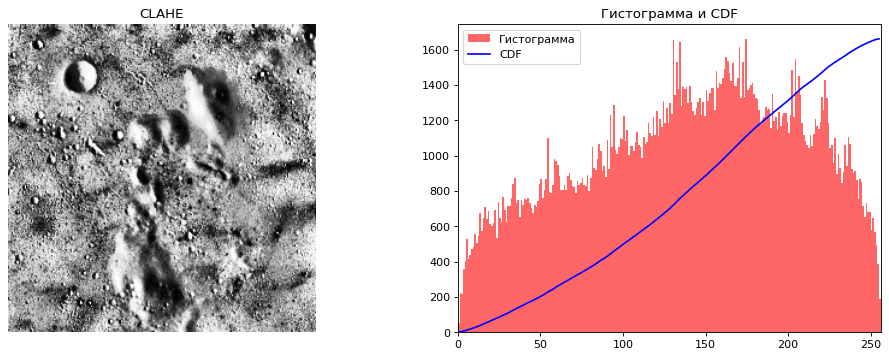

In [20]:
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8, 8))
img_equalized_clahe = clahe.apply(img)
plot_hist(img_equalized_clahe, "CLAHE")

## Упражнение 4

Примените обычное гистограммное выравнивание и CLAHE к предложенному изображению. Визуализируйте исходное, обработанное гистограммным выравниванием и обработанное CLAHE изображения и их гистограммы и CDF.

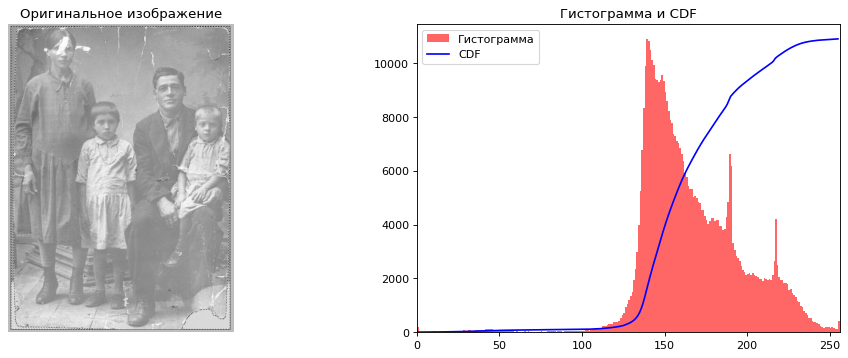

In [21]:
IMG_PATH = "data/image.jpg"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2025.git
    !mv cv_course_2025/seminars/seminar_03/data .

img = cv2.cvtColor(
    src=cv2.imread(IMG_PATH),
    code=cv2.COLOR_RGB2GRAY,
)

plot_hist(img, "Оригинальное изображение")


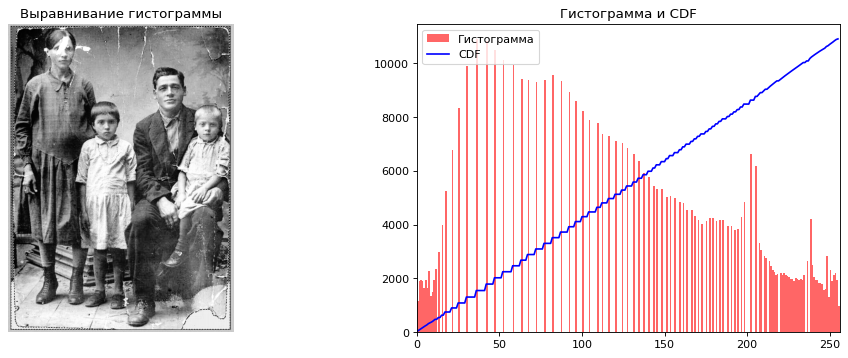

In [22]:
img_equalization = histogram_equalization(img)
plot_hist(img_equalization, "Выравнивание гистограммы")

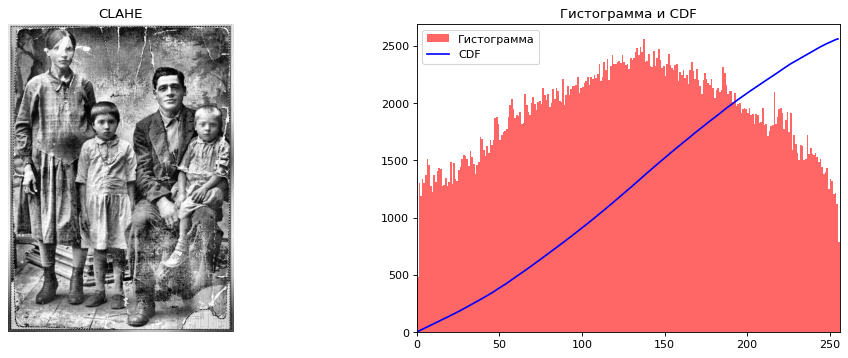

In [23]:
img_clahe = clahe.apply(img)
plot_hist(img_clahe, "CLAHE")

## Другие нелинейные фильтры

Далее в коде будет использоваться пакет `cv2.ximgproc`, который содержит реализации различных нелинейных фильтров. Он не включен в основные пакеты библиотеки OpenCV.

Всего есть 4 разных варианта библиотеки OpenCV:
1. `opencv-python`
2. `opencv-contrib-python`
3. `opencv-python-headless`
4. `opencv-contrib-python-headless`

`cv2.ximgproc` содержится в `opencv-contrib-python` и `opencv-contrib-python-headless`.

**Вы можете установить только одну версию.** Поэтому перед установкой `opencv-contrib-python` или `opencv-contrib-python-headless` удалите `opencv-python` или `opencv-python-headless`.

```bash
pip uninstall opencv-python
pip install opencv-contrib-python
```

https://stackoverflow.com/questions/57427233/module-cv2-cv2-has-no-attribute-ximgproc

### Domain Transform Filter

**Используется для:** Размытия с учетом границ и направлений градиентов.

**Как работает:** Фильтр работает в домене трансформации (Domain Transform) и сохраняет важные детали изображения, размывая шум.

**Пример кода:**

```python
# Используем направляющее изображение с размытием Гаусса
guide = cv2.GaussianBlur(img, (9, 9), 2)

# Применяем Domain Transform Filter
filtered_img = cv2.ximgproc.dtFilter(
    guide=guide,    # Используем размытое изображение как направляющее
    src=img,        # Исходное изображение
    sigmaSpatial=15,  
    sigmaColor=30   
)
```

**Как влияет `guide` в `dtFilter`?**
- Если `guide = img`, фильтр действует как адаптивное сглаживание с сохранением границ.
- Если `guide` – размытое изображение, фильтр будет сильнее размывать гладкие области.
Можно использовать цветное изображение в качестве `guide` для стилизации черно-белого изображения.


### Нелокальные средние (Non-Local Means Denoising)

**Используется для:** шумоподавления с сохранением текстур и деталей.

**Как работает:** усредняет пиксели, используя похожие паттерны в других частях изображения, а не только в локальном окне.

**Пример кода:**

```python
filtered_img = cv2.fastNlMeansDenoising(img, h=10, templateWindowSize=7, searchWindowSize=21)
```

### Направленное сглаживание (Guided Filter)

**Используется для:** удаления шума, улучшения контраста, HDR-тон-маппинга.

**Как работает:** размывает изображение, используя вспомогательное изображение в качестве ориентира, что позволяет сохранить детали.

**Пример кода:**

```python
filtered_img = cv2.ximgproc.guidedFilter(guide=img, src=img, radius=8, eps=0.01)
```

### Морфологические операции

Морфологические операции, такие как эрозия, дилатация, открытие и закрытие, активно используются для обработки бинарных изображений, сегментации и удаления шума. *Эти методы будут рассмотрены в одном из следующих семинаров.*


## Упражнение 5

Подберите подходящие изображения для визуализации результатов работы каждого из упомянутых выше фильтров (кроме морфологических операций, о них позже). Примените каждый из них к выбранным изображениям, показав исходное и обработанное изображения.


In [38]:
!pip3 list | grep opencv
# !pip3 uninstall -y opencv-contrib-python opencv-python
# !pip3 install opencv-contrib-python

opencv-contrib-python     4.11.0.86
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [35]:
saltpeppered_astro = saltpepper_noise(cv2.cvtColor(skimage.data.astronaut(), cv2.COLOR_RGB2GRAY), 0.03)
guided_astro = cv2.ximgproc.guidedFilter(guide=saltpeppered_astro, src=saltpeppered_astro)
show_image(saltpeppered_astro, 'saltpeppered_astro')
show_image(guided_astro, 'guided_astro')


AttributeError: module 'cv2' has no attribute 'ximgproc'